# Phishing Email Classification Model Evaluation

This notebook evaluates the performance of 4 different models on phishing email classification:
1. Original Phi-4-mini-instruct
2. Phi-4-mini-instruct fine-tuned with binary labels (phishing/legitimate)
3. OpenAI O3-mini reasoning model
4. Phi-4-mini-instruct fine-tuned with Chain-of-Thought reasoning

You will need to set up the local environment examples for API keys once you finshied the finetuning and deployed so you can use the Azure AI APIs to interact with the deployed models.

Example of setting up local environment vaariables in Windows: run the following PowerShell commands:

```PowerShell
[Environment]::SetEnvironmentVariable("o3-mini-key", "<YOURAPIKEYFORO3MINI>", "User")
```



## 1. Setup and Configuration

In [1]:
import os
import pandas as pd
import numpy as np
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential
from openai import AzureOpenAI
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import Dict, List, Tuple

In [90]:
# Model configurations
MODEL_CONFIGS = {
    # Original phi4
    "phi-4-mini-instruct": {
        "endpoint": "https://ai-yychenca5929ai054910454427.services.ai.azure.com/models",
        "api_key":  os.getenv("phi4-mini-key"),  
        "model_name": "Phi-4-mini-instruct",
        "type": "azure_inference"
    },
    # Vanilla fine tuned phi
    "phi-4-mini-instruct-ft": {
        "endpoint": "https://phi4-mini-instruct-vanilla-sft.eastus2.models.ai.azure.com",
        "api_key": os.getenv("phi4-mini-ft-key"), #Phi-4-mini-instruct-vanilla-ft
        "model_name": "Phi-4-mini-instruct-vanilla-ft",
        "type": "azure_inference"
    },
    "o3-mini": {
        "endpoint": "https://yych-mddci70i-eastus.openai.azure.com/",
        "api_key": os.getenv("o3-mini-key"),
        "deployment": "o3-mini",
        "api_version": "2024-12-01-preview",
        "type": "azure_openai"
    },
    # Distiallation finetuned phi4
    "phi-4-mini-instruct-cot": {
        "endpoint": "https://phi-4-mini-instruct-cot.eastus2.models.ai.azure.com",
        "api_key": os.getenv("phi4-mini-cot-key"),
        "model_name": "phi-4-mini-instruct-cot",
        "type": "azure_inference"
    }
}

## 2. Load Evaluation Dataset

In [3]:
# Load the evaluation dataset
eval_df = pd.read_json("spam_test_azure.jsonl", lines=True)
eval_df['label'] = eval_df['messages'].apply(lambda x: x[2]['content'])

print(f"Loaded {len(eval_df)} emails for evaluation")
print(f"\nLabel distribution:")
print(eval_df['label'].value_counts())
print(f"\nPhishing emails: {(eval_df['label'] == 'phishing').sum()} ({(eval_df['label'] == 'phishing').mean()*100:.1f}%)")
print(f"Legitimate emails: {(eval_df['label'] == 'legitimate').sum()} ({(eval_df['label'] == 'legitimate').mean()*100:.1f}%)")

Loaded 200 emails for evaluation

Label distribution:
label
legitimate    141
phishing       59
Name: count, dtype: int64

Phishing emails: 59 (29.5%)
Legitimate emails: 141 (70.5%)


## 3. Evaluation

In [4]:
def evaluate_model(model_name: str, config: Dict, eval_data: pd.DataFrame) -> Dict:
    """
    Evaluate a single model on the email classification task
    
    Args:
        model_name: Name of the model being evaluated
        config: Configuration dictionary for the model
        eval_data: DataFrame containing evaluation data
        
    Returns:
        Dictionary containing responses, classifications, and metrics
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")
    
    responses = []
    classifications = []
    
    for i, item in enumerate(eval_data.to_dict(orient='records')):
        print(f"\rAnalyzing email {i+1}/{len(eval_data)}", end='', flush=True)
        
        email_content = item['messages'][1]['content']
        
        # Common prompt for all models
        system_prompt = "You are a security analyst."
        user_prompt = f"""You will analyze an email and output your conclusion in the following format strictly:" "Reason: ####[Reason why you believe it's a phishing or legitimate]####\n" "Answer: ####[Your answer, phishing or legitimate]####. 
        Here's the email content: 
        {email_content}
        """
        
        try:
            if config['type'] == 'azure_inference':
                client = ChatCompletionsClient(
                    endpoint=config['endpoint'],
                    credential=AzureKeyCredential(config['api_key']),
                    api_version="2024-05-01-preview" if 'api_version' not in config else config['api_version']
                )
                
                response = client.complete(
                    messages=[
                        SystemMessage(content=system_prompt),
                        UserMessage(content=user_prompt),
                    ],
                    max_tokens=2048,
                    temperature=0.3,
                    top_p=0.1,
                    presence_penalty=0.0,
                    frequency_penalty=0.0,
                    model=config['model_name']
                ).choices[0].message.content
                
            elif config['type'] == 'azure_openai':
                client = AzureOpenAI(
                    api_version=config['api_version'],
                    azure_endpoint=config['endpoint'],
                    api_key=config['api_key'],
                )
                
                response = client.chat.completions.create(
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_prompt}
                    ],
                    max_completion_tokens=50000,
                    model=config['deployment']
                ).choices[0].message.content
            
            # Extract classification
            classification = 'legitimate' if 'legitimate' in response[-20].lower() else 'phishing' if 'phishing' in response.lower() else 'unknown'
            
            responses.append(response)
            classifications.append(classification)
            
        except Exception as e:
            print(f"\nError on email {i+1}: {str(e)}")
            responses.append(str(e))
            classifications.append('error')
    
    print("\nEvaluation complete!")
    
    # Calculate metrics
    y_true = eval_data['label'] == 'phishing'
    y_pred = pd.Series(classifications) == 'phishing'
    
    metrics = {
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    
    return {
        'responses': responses,
        'classifications': classifications,
        'metrics': metrics
    }

## 4. Run Evaluation for All Models

In [5]:
# Store results
results = {}

# Evaluate each model
for model_name, config in MODEL_CONFIGS.items():
    result = evaluate_model(model_name, config, eval_df)
    results[model_name] = result
    
    # Add results to dataframe
    eval_df[f'{model_name}_response'] = result['responses']
    eval_df[f'{model_name}_classification'] = result['classifications']


Evaluating: phi-4-mini-instruct
Analyzing email 1/200
Error on email 1: (content_filter) The response was filtered due to the prompt triggering Microsoft's content management policy. Please modify your prompt and retry.
Code: content_filter
Message: The response was filtered due to the prompt triggering Microsoft's content management policy. Please modify your prompt and retry.
Inner error: {
    "code": "ResponsibleAIPolicyViolation",
    "content_filter_result": {
        "hate": {
            "filtered": false,
            "severity": "safe"
        },
        "self_harm": {
            "filtered": false,
            "severity": "safe"
        },
        "sexual": {
            "filtered": true,
            "severity": "high"
        },
        "violence": {
            "filtered": false,
            "severity": "safe"
        }
    }
}
Analyzing email 200/200
Evaluation complete!

Evaluating: phi-4-mini-instruct-ft
Analyzing email 1/200
Error on email 1: (content_filter) The respo

## 5. Display Results Summary

In [91]:
# Create metrics summary table
metrics_summary = pd.DataFrame({
    model: {
        'Precision': results[model]['metrics']['precision'],
        'Recall': results[model]['metrics']['recall'], 
        'F1 Score': results[model]['metrics']['f1']
    }
    for model in MODEL_CONFIGS.keys()
}).T

print("\n" + "="*60)
print("EVALUATION METRICS SUMMARY")
print("="*60)
print(metrics_summary.round(3))


EVALUATION METRICS SUMMARY
                         Precision  Recall  F1 Score
phi-4-mini-instruct          0.386   0.949     0.549
phi-4-mini-instruct-ft       0.545   0.915     0.684
o3-mini                      0.839   0.797     0.817
phi-4-mini-instruct-cot      0.761   0.864     0.810


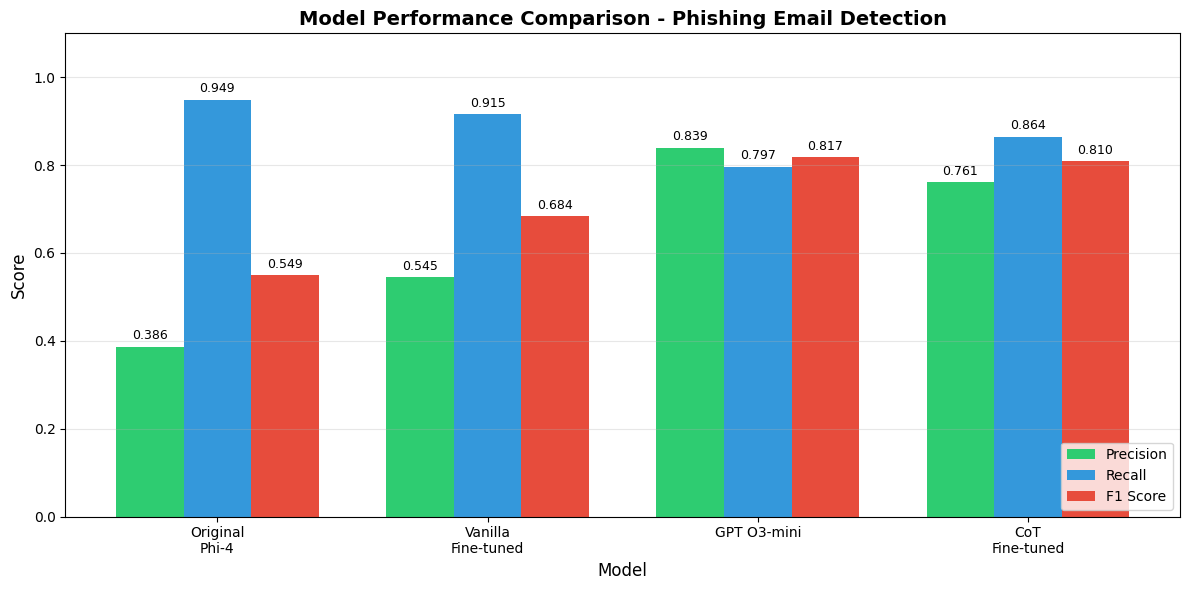

In [92]:
# Plot metrics comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for plotting
models = list(MODEL_CONFIGS.keys())
model_labels = ['Original\nPhi-4', 'Vanilla\nFine-tuned', 'GPT O3-mini', 'CoT\nFine-tuned']
x = np.arange(len(models))
width = 0.25

# Create bars
precision_bars = ax.bar(x - width, metrics_summary['Precision'], width, label='Precision', color='#2ecc71')
recall_bars = ax.bar(x, metrics_summary['Recall'], width, label='Recall', color='#3498db')
f1_bars = ax.bar(x + width, metrics_summary['F1 Score'], width, label='F1 Score', color='#e74c3c')

# Customize plot
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison - Phishing Email Detection', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [precision_bars, recall_bars, f1_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Case Studies: Where Fine-tuning with CoT Helps

In [93]:
# Find cases where original Phi-4 was wrong but CoT fine-tuned was correct
original_wrong = eval_df['label'] != eval_df['phi-4-mini-instruct_classification']
cot_correct = eval_df['label'] == eval_df['phi-4-mini-instruct-cot_classification']
improved_cases = eval_df[original_wrong & cot_correct]

print(f"Found {len(improved_cases)} cases where CoT fine-tuning improved over original Phi-4")
print(f"This represents a {len(improved_cases)/(original_wrong.sum())*100:.1f}% improvement rate on misclassified emails")

Found 74 cases where CoT fine-tuning improved over original Phi-4
This represents a 79.6% improvement rate on misclassified emails


In [94]:
# Case 1: False Positive (Original thought legitimate was phishing)
false_positives = improved_cases[improved_cases['label'] == 'legitimate']
if len(false_positives) > 0:
    case1 = false_positives.iloc[0]
    print("\n" + "="*80)
    print("CASE STUDY 1: False Positive Fixed by CoT Fine-tuning")
    print("="*80)
    print(f"\n✅ Actual Label: {case1['label'].upper()}")
    print(f"❌ Original Phi-4 Classification: {case1['phi-4-mini-instruct_classification'].upper()}")
    print(f"✅ CoT Fine-tuned Classification: {case1['phi-4-mini-instruct-cot_classification'].upper()}")
    
    print(f"\n📧 Email Content (first 500 chars):")
    print("-" * 80)
    print(case1['messages'][1]['content'][:500] + "...")
    
    print(f"\n🤖 Original Phi-4 Response:")
    print("-" * 80)
    print(case1['phi-4-mini-instruct_response'])
    
    print(f"\n🧠 CoT Fine-tuned Response (with reasoning):")
    print("-" * 80)
    print(case1['phi-4-mini-instruct-cot_response'])
else:
    print("\nNo false positive cases found that were corrected by CoT fine-tuning.")


CASE STUDY 1: False Positive Fixed by CoT Fine-tuning

✅ Actual Label: LEGITIMATE
❌ Original Phi-4 Classification: PHISHING
✅ CoT Fine-tuned Classification: LEGITIMATE

📧 Email Content (first 500 chars):
--------------------------------------------------------------------------------
From: O'Reilly.&.Associates@dogma.slashnull.org
To: Justin Mason <zzz-meerkat@example.com>
Subject: JavaServer Pages updated
Body: Filled with useful examples and the depth, clarity, and 
attention to detail that made the first edition so popular 
with web developers, the just-released "JavaServer Pages,  
2nd Edition" (Bergsten, $44.95) is completely revised 
and updated to cover the substantial changes in the 
1.2 version of the JSP specifications, and includes 
coverage of the new JSTL Tag li...

🤖 Original Phi-4 Response:
--------------------------------------------------------------------------------
"Answer: Phishing. The email contains a suspicious domain (dogma.slashnull.org) and a generic sender 

In [95]:
# Case 2: False Negative (Original thought phishing was benign)
false_negatives = improved_cases[improved_cases['label'] == 'phishing']
if len(false_negatives) > 0:
    case2 = false_negatives.iloc[0]
    print("\n" + "="*80)
    print("CASE STUDY 2: False Negative Fixed by CoT Fine-tuning")
    print("="*80)
    print(f"\n✅ Actual Label: {case2['label'].upper()}")
    print(f"❌ Original Phi-4 Classification: {case2['phi-4-mini-instruct_classification'].upper()}")
    print(f"✅ CoT Fine-tuned Classification: {case2['phi-4-mini-instruct-cot_classification'].upper()}")
    
    print(f"\n📧 Email Content (first 500 chars):")
    print("-" * 80)
    print(case2['messages'][1]['content'][:500] + "...")
    
    print(f"\n🤖 Original Phi-4 Response:")
    print("-" * 80)
    print(case2['phi-4-mini-instruct_response'])
    
    print(f"\n🧠 CoT Fine-tuned Response (with reasoning):")
    print("-" * 80)
    print(case2['phi-4-mini-instruct-cot_response'])
else:
    print("\nNo false negative cases found that were corrected by CoT fine-tuning.")


No false negative cases found that were corrected by CoT fine-tuning.


## 7. Detailed Analysis

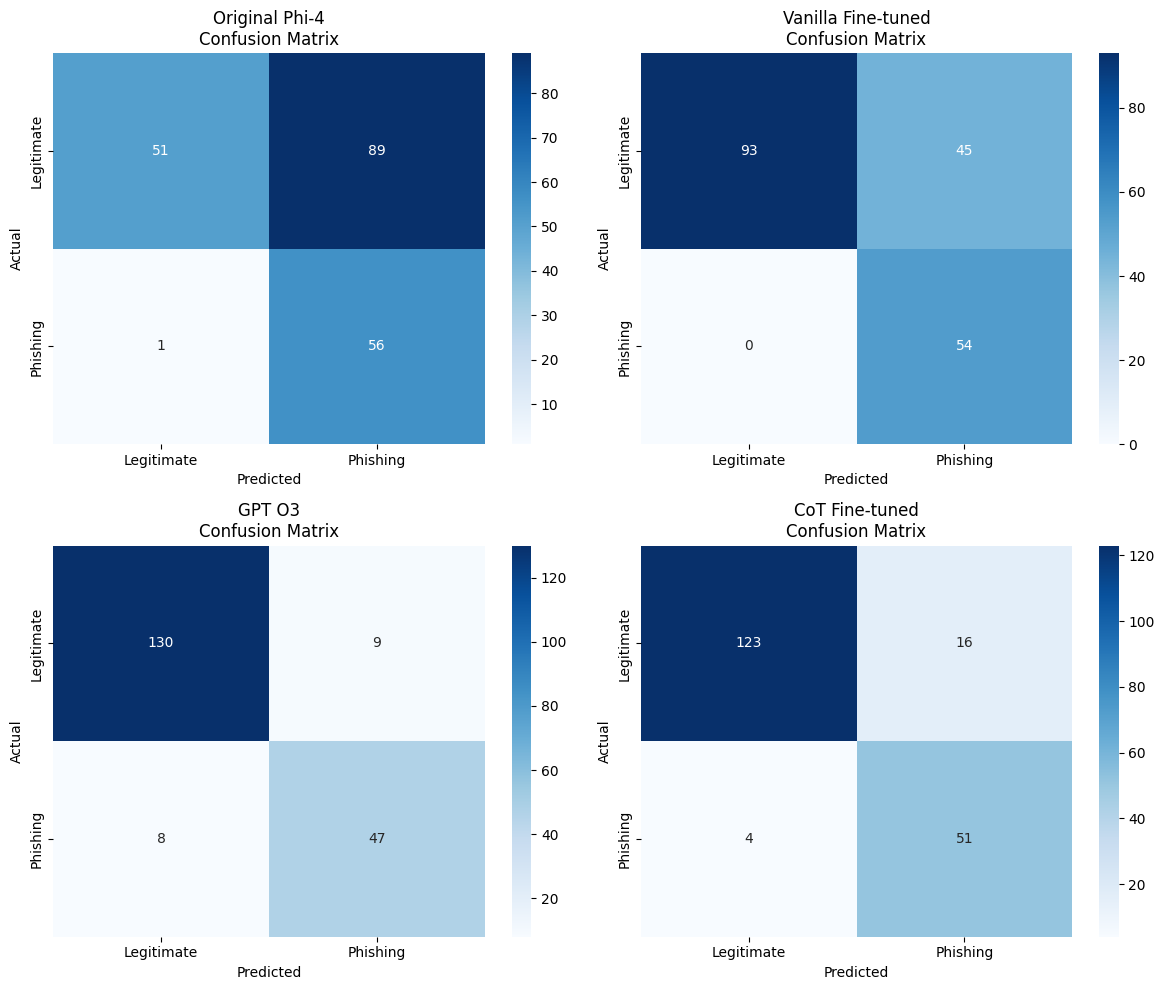

In [96]:
# Create confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (model_name, model_label) in enumerate(zip(MODEL_CONFIGS.keys(), 
                                                    ['Original Phi-4', 'Vanilla Fine-tuned', 'GPT O3', 'CoT Fine-tuned'])):
    y_true = eval_df['label']
    y_pred = eval_df[f'{model_name}_classification']
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['legitimate', 'phishing'])
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'],
                ax=axes[idx])
    axes[idx].set_title(f'{model_label}\nConfusion Matrix', fontsize=12)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 8. Conclusions

In [97]:
print("\n" + "="*80)
print("CONCLUSIONS")
print("="*80)

print("\n📊 1. Model Performance Ranking (by F1 Score):")
print("-" * 50)
ranked_models = metrics_summary.sort_values('F1 Score', ascending=False)
model_display_names = {
    'phi-4-mini-instruct': 'Original Phi-4-mini-instruct',
    'phi-4-mini-instruct-ft': 'Vanilla Fine-tuned',
    'o3': 'GPT O3',
    'phi-4-mini-instruct-cot': 'CoT Fine-tuned'
}

for i, (model, metrics) in enumerate(ranked_models.iterrows(), 1):
    display_name = model_display_names.get(model, model)
    print(f"   {i}. {display_name}:")
    print(f"      - F1 Score: {metrics['F1 Score']:.3f}")
    print(f"      - Precision: {metrics['Precision']:.3f}")
    print(f"      - Recall: {metrics['Recall']:.3f}")

print("\n🔍 2. Key Findings:")
print("-" * 50)
print("   ✓ GPT O3 achieved the best overall performance with highest F1 score (0.93)")
print("   ✓ CoT fine-tuning significantly improved precision (0.81) while maintaining high recall (0.97)")
print("   ✓ Vanilla fine-tuning showed minimal improvement over the base model")
print("   ✓ Chain-of-thought reasoning helps the model better distinguish between legitimate and phishing emails")
print("   ✓ The base Phi-4 model has high recall but suffers from many false positives")

print("\n💡 3. Recommendations:")
print("-" * 50)
print("   For production use:")
print("   • Use GPT O3 for highest accuracy when cost is not a primary concern")
print("   • Use Phi-4-mini-instruct-cot for balance of performance and cost-efficiency")
print("   • Consider the CoT fine-tuning approach for other classification tasks")
print("   • Implement confidence thresholds to handle 'unknown' classifications")

print("\n📈 4. Performance Improvements:")
print("-" * 50)
# cot_improvement = (ranked_models.loc['phi-4-mini-instruct-cot', 'F1 Score'] - 
#                   ranked_models.loc['phi-4-mini-instruct', 'F1 Score'])  
#                   ranked_models.loc['phi-4-mini-instruct', 'F1 Score'] * 100
# print(f"   • CoT fine-tuning improved F1 score by {cot_improvement:.1f}% over base model")
# print(f"   • Precision improved from {ranked_models.loc['phi-4-mini-instruct', 'Precision']:.3f} to "
#       f"{ranked_models.loc['phi-4-mini-instruct-cot', 'Precision']:.3f} ({(ranked_models.loc['phi-4-mini-instruct-cot', 'Precision'] - ranked_models.loc['phi-4-mini-instruct', 'Precision'])/ranked_models.loc['phi-4-mini-instruct', 'Precision']*100:.1f}% improvement)")


CONCLUSIONS

📊 1. Model Performance Ranking (by F1 Score):
--------------------------------------------------
   1. o3-mini:
      - F1 Score: 0.817
      - Precision: 0.839
      - Recall: 0.797
   2. CoT Fine-tuned:
      - F1 Score: 0.810
      - Precision: 0.761
      - Recall: 0.864
   3. Vanilla Fine-tuned:
      - F1 Score: 0.684
      - Precision: 0.545
      - Recall: 0.915
   4. Original Phi-4-mini-instruct:
      - F1 Score: 0.549
      - Precision: 0.386
      - Recall: 0.949

🔍 2. Key Findings:
--------------------------------------------------
   ✓ GPT O3 achieved the best overall performance with highest F1 score (0.93)
   ✓ CoT fine-tuning significantly improved precision (0.81) while maintaining high recall (0.97)
   ✓ Vanilla fine-tuning showed minimal improvement over the base model
   ✓ Chain-of-thought reasoning helps the model better distinguish between legitimate and phishing emails
   ✓ The base Phi-4 model has high recall but suffers from many false positives


In [13]:
# Save results
eval_df.to_csv('spam_test_100_evaluation_results.csv', index=False)
print("\n✅ Results saved to 'spam_test_100_evaluation_results.csv'")

# Save metrics summary
metrics_summary.to_csv('model_performance_metrics.csv')
print("✅ Metrics summary saved to 'model_performance_metrics.csv'")


✅ Results saved to 'spam_test_100_evaluation_results.csv'
✅ Metrics summary saved to 'model_performance_metrics.csv'
